## Imports 

In [24]:
import re
import spacy
import statistics
import numpy as np
import pandas as pd
import torch #includes glove
import torchtext.vocab as vocab
from torchtext.vocab import GloVe 
from gensim.models import KeyedVectors
from tqdm import tqdm
from langdetect import detect
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from nltk import download, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, RSLPStemmer
from nltk.stem.wordnet import WordNetLemmatizer

## Data Import

In [25]:
airbnb_df_train = pd.read_excel('./1.data_raw/train.xlsx')
airbnb_df_test = pd.read_excel('./1.data_raw/test.xlsx')
airbnb_df_train_reviews = pd.read_excel('./1.data_raw/train_reviews.xlsx')
airbnb_df_test_reviews = pd.read_excel('./1.data_raw/test_reviews.xlsx')
pd.options.display.max_colwidth = 50

## First Data Exploration

In [26]:
airbnb_df_train

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0
...,...,...,...,...
12491,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1


In [28]:
airbnb_df_train_reviews

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."
...,...,...
721397,12494,"We had a good time, the apartment has a great ..."
721398,12494,Great apartment in very central location. The ...
721399,12494,"We are Airbnb Super Hosts too, so trust me, Li..."
721400,12494,We had a lovely stay at this apartment. Sofia ...


## Merging all Languages

In [52]:
grouped_reviews_allLang = airbnb_df_test_reviews.groupby('index')['comments'].apply(lambda x: ''.join(str(x))).reset_index()

In [53]:
merged_df_allLang = pd.merge(airbnb_df_train, grouped_reviews_allLang, on='index', how='left')

In [55]:
merged_df_allLang.to_csv("/Users/huberto/Desktop/merged_test_df_train.csv")

In [56]:
merged_df_allLang

,index,description,host_about,unlisted,comments
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,0 Thank you very much Antonio ! All has b...
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,"125 This is a beautiful, bright apartment i..."
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,NaN
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,136 Claudia was a great host. She met us a...
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,153 La maison est exactement comme sur les ...
...,...,...,...,...,...
12491,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0,NaN
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0,NaN
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,NaN
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1,NaN


## Language Detection

In [6]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'Unknown'

### Language detection for reviews

In [7]:
airbnb_df_train_reviews["lang_comments"] = airbnb_df_train_reviews["comments"].apply(detect_language)

In [15]:
airbnb_df_train_reviews

,index,comments,lang_comments
0,1,this is a very cozy and comfortable house to s...,en
1,1,good<br/>,cy
2,1,"My first hostel experience, and all I have to ...",en
3,1,Das Hostel war neu und deshalb funktionierte a...,de
4,1,"It was fine for a dorm, but I think for the pe...",en
...,...,...,...
721397,12494,"We had a good time, the apartment has a great ...",en
721398,12494,Great apartment in very central location. The ...,en
721399,12494,"We are Airbnb Super Hosts too, so trust me, Li...",en
721400,12494,We had a lovely stay at this apartment. Sofia ...,en


### Language detection for desc/host_about

In [16]:
airbnb_df_train["lang_desc"] = airbnb_df_train["description"].apply(detect_language)

In [17]:
airbnb_df_train["lang_host"] = airbnb_df_train["host_about"].apply(detect_language)

,index,description,host_about,unlisted,lang_desc,lang_host
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr
...,...,...,...,...,...,...
12491,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0,en,en
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0,en,en
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,en
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1,pt,pt


## Import detected data

In [50]:
df_train_detected = pd.read_csv("./2.data_detected/airbnb_df_train_detected.csv", index_col="index",).drop("Unnamed: 0",axis=1)
df_train_reviews_detected = pd.read_csv("./2.data_detected/airbnb_df_train__reviews_detected.csv", index_col="index").drop("Unnamed: 0",axis=1)

,description,host_about,unlisted,lang_desc,lang_host
index,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en
4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en
5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr
...,...,...,...,...,...
12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0,en,en
12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0,en,en
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,en


In [36]:
merged_test_df_train = pd.merge(df_train_detected, df_train_reviews_detected, on='index', how='left')

In [48]:
merged_test_df_train

,description,host_about,unlisted,lang_desc,lang_host,comments,lang_comments,Concatenated_Text
index,,,,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,this is a very cozy and comfortable house to s...,en,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,good<br/>,cy,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"My first hostel experience, and all I have to ...",en,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,Das Hostel war neu und deshalb funktionierte a...,de,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"It was fine for a dorm, but I think for the pe...",en,"This is a shared mixed room in our hostel, wit..."
...,...,...,...,...,...,...,...,...
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,en,"We are Airbnb Super Hosts too, so trust me, Li...",en,Enjoy breakfast in the sleek kitchen with its ...
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,en,We had a lovely stay at this apartment. Sofia ...,en,Enjoy breakfast in the sleek kitchen with its ...
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,en,"Clean, very good position, easy checkin, the p...",en,Enjoy breakfast in the sleek kitchen with its ...


,description,host_about,unlisted,lang_host,comments,lang_comments,Concatenated_Text
index,,,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,pt,this is a very cozy and comfortable house to s...,en,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,pt,good<br/>,cy,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,pt,"My first hostel experience, and all I have to ...",en,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,pt,Das Hostel war neu und deshalb funktionierte a...,de,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,pt,"It was fine for a dorm, but I think for the pe...",en,"This is a shared mixed room in our hostel, wit..."
...,...,...,...,...,...,...,...
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,"We are Airbnb Super Hosts too, so trust me, Li...",en,Enjoy breakfast in the sleek kitchen with its ...
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,We had a lovely stay at this apartment. Sofia ...,en,Enjoy breakfast in the sleek kitchen with its ...
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,"Clean, very good position, easy checkin, the p...",en,Enjoy breakfast in the sleek kitchen with its ...


In [40]:
merged_test_df_train.to_csv("/Users/huberto/Desktop/merged_test_df_train.csv")

In [47]:
merged_test_df_train

,description,host_about,unlisted,lang_desc,lang_host,comments,lang_comments,Concatenated_Text
index,,,,,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,this is a very cozy and comfortable house to s...,en,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,good<br/>,cy,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"My first hostel experience, and all I have to ...",en,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,Das Hostel war neu und deshalb funktionierte a...,de,"This is a shared mixed room in our hostel, wit..."
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"It was fine for a dorm, but I think for the pe...",en,"This is a shared mixed room in our hostel, wit..."
...,...,...,...,...,...,...,...,...
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,en,"We are Airbnb Super Hosts too, so trust me, Li...",en,Enjoy breakfast in the sleek kitchen with its ...
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,en,We had a lovely stay at this apartment. Sofia ...,en,Enjoy breakfast in the sleek kitchen with its ...
12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,en,"Clean, very good position, easy checkin, the p...",en,Enjoy breakfast in the sleek kitchen with its ...


In [331]:
df_train_detected.loc[(df_train_detected["lang_host"] == "en") & (df_train_detected["lang_desc"] == "en")]

,description,host_about,unlisted,lang_desc,lang_host
index,,,,,
3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en
6,"IMPORTANT: In response to COVID-19, this prope...","Hi, we are Homing - a company that develops it...",0,en,en
7,This is my home that I rent out when I'm trave...,Globe trotter. I'm of Portuguese nationality w...,1,en,en
8,Find tranquility in this meticulously curated ...,I travel a lot and I love it. _x000D_\nOrigina...,0,en,en
9,Charming apartment with one bedroom with doubl...,"Isabel & Helder, portugueses, parents of three...",0,en,en
...,...,...,...,...,...
12489,Feel at home wherever you choose to live with ...,"We’re Blueground, a global proptech company wi...",1,en,en
12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0,en,en
12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0,en,en


### Count number of different Languages

In [2]:
#airbnb_df_train["lang_desc"].value_counts()

In [3]:
#airbnb_df_train["lang_host"].value_counts()

In [4]:
#airbnb_df_train_reviews["lang_comments"].value_counts()

In [332]:
def create_df(df, df_review, language):

    columns_to_drop = ['lang_desc', 'lang_host']
    
    df = df[(df['lang_desc'] == language) & (df['lang_host'] == language)]
    df_review = df_review[df_review['lang_comments'] == language]
    grouped_reviews = df_review.groupby('index')['comments'].apply(lambda x: ''.join(str(x))).reset_index()
    merged_df = pd.merge(df, grouped_reviews, on='index', how='left')
    merged_df = merged_df.drop(columns=columns_to_drop)
    merged_df = merged_df[["index",	"description", "host_about", "comments", "unlisted"]]

    return merged_df

### join all English host_about/desc with English comments

In [333]:
merged_df_english = create_df(df_train_detected, df_train_reviews_detected, "en")

In [334]:
merged_df_english

,index,description,host_about,comments,unlisted
0,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",NaN,1
1,6,"IMPORTANT: In response to COVID-19, this prope...","Hi, we are Homing - a company that develops it...",NaN,0
2,7,This is my home that I rent out when I'm trave...,Globe trotter. I'm of Portuguese nationality w...,NaN,1
3,8,Find tranquility in this meticulously curated ...,I travel a lot and I love it. _x000D_\nOrigina...,index\n8 Shani was very helpful throughout ...,0
4,9,Charming apartment with one bedroom with doubl...,"Isabel & Helder, portugueses, parents of three...",index\n9 Great little space; lovely hosts -...,0
...,...,...,...,...,...
8201,12489,Feel at home wherever you choose to live with ...,"We’re Blueground, a global proptech company wi...",NaN,1
8202,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,index\n12492 We were very happy to find thi...,0
8203,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,"index\n12493 Nice place, nice location, ...",0
8204,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,index\n12494 We had a very lovely stay in L...,0


### Seems like NaN values is a good indication if a flat is getting listed again or not. Makes sense in real life context, because flats that dont have visitors are more likly to be unlisted in the future.

## Preprocessing English

In [346]:
def preprocessing_eng(row, tokenize, stop, lemmatize, stemmertize):
    updates = []
    
    for j in tqdm(row):
        
        text = j
        
        #LOWERCASE TEXT
        text = str(text).lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        if tokenize:
            tokens = word_tokenize(text)
            text = " ".join(tokens)
        
        #REMOVE STOPWORDS
        if stop:
            stop_eng = set(stopwords.words('english'))
            text = " ".join([word for word in text.split() if word not in stop_eng])
        
        #Lemmatize
        if lemmatize:
            lemma_eng = WordNetLemmatizer()
            text = " ".join(lemma_eng.lemmatize(word) for word in text.split())
            
        
        #Stemming
        if stemmertize:
            stemmer_eng = SnowballStemmer('english')
            text = " ".join(stemmer_eng.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [347]:
download('wordnet')
download('stopwords')
download('punkt')
columns_to_apply = ['description', 'host_about', 'comments']
merged_df_english[columns_to_apply] = merged_df_english[columns_to_apply].astype(str).apply(lambda row: preprocessing_eng(row=row,
                                                                                                                        tokenize=True,
                                                                                                                        stop=True,
                                                                                                                        lemmatize = False, 
                                                                                                                        stemmertize = False
                                                                                                                        )
                                                                                            )

[nltk_data] Downloading package wordnet to /Users/huberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/huberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 8206/8206 [00:02<00:00, 2893.89it/s]


In [348]:
merged_df_english

,index,description,host_about,comments,unlisted,Concatenated_Text
0,3,trafaria house cozy familiar villa facilities ...,social person liking communicate reading trave...,nan,1,NaN
1,6,important response covid property extended cle...,hi homing company develops activity tourism pr...,nan,0,NaN
2,7,home rent traveling perfect vacation without c...,globe trotter portuguese nationality german fa...,nan,1,NaN
3,8,find tranquility meticulously curated lifestyl...,travel lot love x originally israel currently ...,index shani helpful throughout process accommo...,0,Find tranquility in this meticulously curated ...
4,9,charming apartment one bedroom double bed doub...,isabel helder portugueses parents three wonder...,index great little space lovely hosts clean w ...,0,Charming apartment with one bedroom with doubl...
...,...,...,...,...,...,...
8201,12489,feel home wherever choose live blueground love...,blueground global proptech company several tho...,nan,1,NaN
8202,12492,cat bairro alto cozy apartment lisbon city cen...,travelling one favorite hobbies already visite...,index happy find place com great stay lisbon a...,0,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...
8203,12493,beautifully located heart lisbon historic cent...,founded travel enthusiasts like bnbird wants c...,index nice place nice location easy communicat...,0,Beautifully located in the heart of Lisbon's h...
8204,12494,enjoy eakfast sleek kitchen freestanding knott...,portugal love dance travel x pleasure welcome ...,index lovely stay lisbon apartm liliana apartm...,0,Enjoy breakfast in the sleek kitchen with its ...


### join all French host_about/desc with French comments

In [10]:
merged_df_french = create_df(df_train_detected, df_train_reviews_detected, "fr")

In [352]:
merged_df_french

,index,description,host_about,comments,unlisted
0,5,joli appartement bordure mer min avoir pied pl...,famille deux enfant an habit pendant plusieurs...,index tr bel appartement magnifique voir appar...,0
1,189,hostel maison ville location possible chame in...,maison typique trois chame individuel r servab...,nan,0
2,192,appartement tr chaleureux beaucoup luminosit b...,teresa novice domaine location esp r apparteme...,index appartement spacieux propre situ quelqu ...,0
3,301,chame double tout confort grand maison terrain...,couple fran ais install portugal o cr maison h...,index tout abord tr bel propri name dtyp object,0
4,329,situ pied panth quartier alfamer venir journer...,romain couple tomb sou charm colmar lisbonn e ...,index appartement tr bien situ quartier appart...,1
...,...,...,...,...,...
100,11799,appartement pi enti rement r nov situer quarti...,bonjour appeler leo fran ais origine chinois m...,index accueil tr chaleureux pedro ami leo exce...,0
101,11878,chame sexy in lover chame nomeux miroir plafon...,mari dominiqu proposer deux capital escapade r...,nan,0
102,11997,logement affiche style r solument unique magni...,aimer paisagem montagne tout loisir,nan,1
103,12210,joli maison typique portugais enti rement cl t...,christophe lila mari trois enfant,index pass tr bon ce joli name dtyp object,0


## Preprocessing French

In [16]:
#!pip3 -m spacy download fr_core_news_md

In [12]:
def preprocessing_fr(row, tokenize, stop, lemmatize, stemmertize):
    updates = []
    
    for j in tqdm(row):
        
        text = j
        
        #LOWERCASE TEXT
        text = str(text).lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        if tokenize:
            tokens = word_tokenize(text, language="french")
            text = " ".join(tokens)
 
        #REMOVE STOPWORDS
        if stop:
            stop_fr = set(stopwords.words('french'))
            text = " ".join([word for word in text.split() if word not in stop_fr])
        

        #Lemmatize
        if lemmatize:
            lemma_fr = spacy.load("fr_core_news_md")
            doc = lemma_fr(text)
            #for word in doc:
            text = " ".join(i.lemma_ for i in doc)
        
        #Stemming
        if stemmertize:
            stemmer_fr = SnowballStemmer('french')
            stem_doc = stemmer_fr(text)
            for word in stem_doc:
                text = " ".join(stemmer_fr.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [353]:
download('wordnet')
download('stopwords')
columns_to_apply = ['description', 'host_about', 'comments']
merged_df_french[columns_to_apply] = merged_df_french[columns_to_apply].astype(str).apply(lambda x: preprocessing_fr(row=x,
                                                                                                                     tokenize=True,
                                                                                                                     stop=True,
                                                                                                                     lemmatize = False, 
                                                                                                                     stemmertize = False
                                                                                                                    )
                                                                                         )

[nltk_data] Downloading package wordnet to /Users/huberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
  0%|          | 0/105 [00:00<?, ?it/s]

100%|██████████| 105/105 [00:00<00:00, 2909.81it/s]


In [354]:
merged_df_french

,index,description,host_about,comments,unlisted
0,5,joli appartement bordure mer min avoir pied pl...,famille deux enfant an habit pendant plusieurs...,index tr bel appartement magnifique voir appar...,0
1,189,hostel maison ville location possible chame in...,maison typique trois chame individuel r servab...,nan,0
2,192,appartement tr chaleureux beaucoup luminosit b...,teresa novice domaine location esp r apparteme...,index appartement spacieux propre situ quelqu ...,0
3,301,chame double tout confort grand maison terrain...,couple fran ais install portugal o cr maison h...,index tout abord tr bel propri name dtyp object,0
4,329,situ pied panth quartier alfamer venir journer...,romain couple tomb sou charm colmar lisbonn e ...,index appartement tr bien situ quartier appart...,1
...,...,...,...,...,...
100,11799,appartement pi enti rement r nov situer quarti...,bonjour appeler leo fran ais origine chinois m...,index accueil tr chaleureux pedro ami leo exce...,0
101,11878,chame sexy in lover chame nomeux miroir plafon...,mari dominiqu proposer deux capital escapade r...,nan,0
102,11997,logement affiche style r solument unique magni...,aimer paisagem montagne tout loisir,nan,1
103,12210,joli maison typique portugais enti rement cl t...,christophe lila mari trois enfant,index pass tr bon joli name dtyp object,0


### join all Portuguese host_about/desc with Portuguese comments'

In [23]:
merged_df_pt = create_df(df_train_detected, df_train_reviews_detected, "pt")

In [24]:
merged_df_pt

,index,description,host_about,comments,unlisted
0,13,O proprietário recebe os hospedes pessoalmente...,"Faço questão de receber os hospedes, para que ...",NaN,0
1,34,Simplifique neste espaço tranquilo e de locali...,"Ola sou Carla, tenho prazer em recebê-los em m...",NaN,1
2,64,"Apartamento composto por uma suite, sala de es...",Apaixonada por Portugal!,NaN,1
3,67,O apartamento está decorado com extremo bom go...,Sou uma pessoa otimista que vive a vida com a ...,NaN,0
4,87,"Óptimo espaço exterior, ideal para quem gosta ...","O meu nome é Cátia, nasci e cresci em Sintra, ...",NaN,1
...,...,...,...,...,...
1084,12457,Casa aconchegante familiar <br />Com ótimas co...,Boa pessoa,"index\n12457 Excelente localização, boas ár...",0
1085,12461,Bem vindo a Lisboa!<br />Este charmoso apartam...,Tenho 38 anos e sou Assistente social de forma...,index\n12461 Excelente apartamento. Um agra...,0
1086,12470,"Apartamento para 6 pessoas com 2 quartos, sala...","Chamo-me Margarida. Gosto do mar, praia, do so...",index\n12470 quem quiser passar uns dias nu...,0
1087,12476,"Apartamento numa zona muito calma de Lisboa, m...","O apartamento é muito, muito simples, mas tem ...",NaN,0


## Preprocessing Portuguese

In [22]:
#!python -m spacy download pt_core_news_sm

In [33]:
def preprocessing_pt(row, tokenize, stop, lemmatize, stemmertize):
    updates = []
    
    for j in tqdm(row):
        
        text = j
        
        #LOWERCASE TEXT
        text = str(text).lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        if tokenize:
            tokens = word_tokenize(text, language="portuguese")
            text = " ".join(tokens)
            
        #REMOVE STOPWORDS
        if stop:
            stop_pt = set(stopwords.words('portuguese'))
            text = " ".join([word for word in text.split() if word not in stop_pt])
            
        #Lemmatize
        if lemmatize:
            lemma_pt = spacy.load("pt_core_news_sm")
            doc = lemma_pt(text)
            #for word in doc:
            text = " ".join(i.lemma_ for i in doc)
        
        #Stemming
        if stemmertize:
            stemmer_pt = RSLPStemmer()
            stem_doc = stemmer_pt(text)
            for word in stem_doc:
                text = " ".join(stemmer_pt.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [34]:
download('wordnet')
download('stopwords')
columns_to_apply = ['description', 'host_about', 'comments']
merged_df_pt[columns_to_apply] = merged_df_pt[columns_to_apply].astype(str).apply(lambda row: preprocessing_pt(row=row,
                                                                                                             tokenize=True,
                                                                                                             stop=True,
                                                                                                             lemmatize = True, 
                                                                                                             stemmertize = False
                                                                                                            )
                                                                                )

[nltk_data] Downloading package wordnet to /Users/huberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1089/1089 [03:15<00:00,  5.56it/s]


In [35]:
merged_df_pt

,index,description,host_about,comments,unlisted
0,13,propriet rio receber hospede pessoalmente hosp...,fa quest receber hospede sintar casa,nan,0
1,34,simplifique Espa tranquilo localizar central q...,olar carlar prazer receb los alojamentar bem v...,nan,1
2,64,apartamento compor suite sala tv kitchenette a...,apaixonar Portugal,nan,1
3,67,apartamento est decorar extremo bom gosto comb...,pessoa otimista viver vida alegrio entusiasmo ...,nan,0
4,87,ptimo espa exterior ideal gostar desfrutar ar ...,nome c tia nascer crescir sintro Vila cora apa...,nan,1
...,...,...,...,...,...
1084,12457,casa aconchegante familiar timar condi es pert...,bom pessoa,index excelente localizar bom reo excelente i ...,0
1085,12461,bem vir Lisboa charmoso apartamento ficar bair...,ano assistente social forma h ano decidir dedi...,index excelente apartamento agradecimento espe...,0
1086,12470,apartamento pessoa quarto sala terra m s cadei...,chamar margarer gostar mar praia sol Portugal ...,index querer passar dia sitio clamo casa mt be...,0
1087,12476,apartamento zona calmo Lisboa pr ximo Centro c...,apartamento simples charme sala Sof s wi fi gr...,nan,0


In [36]:
merged_df_pt.to_csv("./3.data_train/merged_df_pt.csv")

## TF - IDF, Train and Evaluation of Estimators

In [111]:
def create_target(df):
    # Concatenate text columns into a single column
    df['Concatenated_Text'] = df['description'] + ' ' + df['host_about'] + ' ' + df['comments']

    #separate features and taget
    X = df['Concatenated_Text'].astype(str)
    y = df['unlisted'].astype(int)

    return X, y

In [112]:
def custom_fit_evaluate(X,y,estimator):
    tfidf = TfidfVectorizer()
    scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        x_train, x_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        
        x_train_tfidf = tfidf.fit_transform(x_train)
        x_val_tfidf = tfidf.transform(x_val)
        
        estimator.fit(x_train_tfidf, y_train)
        score = estimator.score(x_val_tfidf, y_val)
        scores.append(score)

    score_avg = statistics.mean(scores)

    return score_avg, scores

In [113]:
X_eng, y_eng = create_target(merged_df_english)

In [114]:
rf_classifier_eng = RandomForestClassifier()

In [115]:
custom_fit_evaluate(X_eng, y_eng, rf_classifier_eng)

(0.8694851999723884,
 [0.8739342265529841,
  0.8604509445460086,
  0.8677635588056063,
  0.8689823278488726,
  0.8762949421084705])

In [116]:
modelknn_word_eng = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [117]:
custom_fit_evaluate(X_eng, y_eng, modelknn_word_eng)

(0.8602238912875827,
 [0.8629719853836785,
  0.8494820231566118,
  0.8555758683729433,
  0.8653260207190737,
  0.8677635588056063])

In [118]:
rc = RidgeClassifier()

In [119]:
custom_fit_evaluate(X_eng, y_eng, rc)

(0.8697285826577033,
 [0.876979293544458,
  0.8610603290676416,
  0.8634978671541743,
  0.8689823278488726,
  0.8781230956733699])

In [120]:
lr = LogisticRegression()

In [121]:
custom_fit_evaluate(X_eng, y_eng, lr)

(0.8676569721828213,
 [0.8745432399512789,
  0.8574040219378428,
  0.8616697135892748,
  0.8671541742839732,
  0.8775137111517367])

In [ ]:
def prediction(row):
    lang = detect(row)
    if lang == "en":
        preprocessing_eng(row)
        return model_eng.predict(row)
    elif lang == "fr":
        preprocessing_fr(row)
        return model_fr.predict(row)
    elif lang == "pt":
        preprocessing_pt(row)
        return model_pt.predict(row)
    else:
        translate_to_english
        preprocessing_eng(row)
        return model_eng.predict(row)


df_test_["prediction"] = df.apply(lambda row: prediction(row))

In [37]:
merged_df_test_pt = pd.read_csv("./3.data_train/merged_df_pt.csv", index_col="index",).drop("Unnamed: 0",axis=1)

In [38]:
merged_df_test_pt

,description,host_about,comments,unlisted
index,,,,
13,propriet rio receber hospede pessoalmente hosp...,fa quest receber hospede sintar casa,NaN,0
34,simplifique Espa tranquilo localizar central q...,olar carlar prazer receb los alojamentar bem v...,NaN,1
64,apartamento compor suite sala tv kitchenette a...,apaixonar Portugal,NaN,1
67,apartamento est decorar extremo bom gosto comb...,pessoa otimista viver vida alegrio entusiasmo ...,NaN,0
87,ptimo espa exterior ideal gostar desfrutar ar ...,nome c tia nascer crescir sintro Vila cora apa...,NaN,1
...,...,...,...,...
12457,casa aconchegante familiar timar condi es pert...,bom pessoa,index excelente localizar bom reo excelente i ...,0
12461,bem vir Lisboa charmoso apartamento ficar bair...,ano assistente social forma h ano decidir dedi...,index excelente apartamento agradecimento espe...,0
12470,apartamento pessoa quarto sala terra m s cadei...,chamar margarer gostar mar praia sol Portugal ...,index querer passar dia sitio clamo casa mt be...,0


## GloVe

## Preprocessing

In [391]:
def preprocessing_fr(row, tokenize, stop, lemmatize, stemmertize):
    updates = []
    
    for j in tqdm(row):
        
        text = j
        
        #LOWERCASE TEXT
        text = str(text).lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        if tokenize:
            tokens = word_tokenize(text)
            text = " ".join(tokens)
 
        #REMOVE STOPWORDS
        if stop:
            stop_fr = set(stopwords.words('french'))
            text = " ".join([word for word in text.split() if word not in stop_fr])
        

        #Lemmatize
        if lemmatize:
            lemma_fr = spacy.load("fr_core_news_md")
            doc = lemma_fr(text)
            #for word in doc:
            text = " ".join(i.lemma_ for i in doc)
        
        #Stemming
        if stemmertize:
            stemmer_fr = SnowballStemmer('french')
            stem_doc = stemmer_fr(text)
            for word in stem_doc:
                text = " ".join(stemmer_fr.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [392]:
#download('wordnet')
#download('stopwords')
columns_to_apply = ['description', 'host_about', 'comments']
merged_df_allLang[columns_to_apply] = merged_df_allLang[columns_to_apply].astype(str).apply(lambda row: preprocessing_pt(row=row,
                                                                                                             tokenize=True,
                                                                                                             stop=False,
                                                                                                             lemmatize = False, 
                                                                                                             stemmertize = False
                                                                                                            )
                                                                                )

100%|██████████| 12496/12496 [00:01<00:00, 10011.77it/s]


In [60]:
global_vectors = GloVe(name='840B', dim=300)

.vector_cache/glove.840B.300d.zip: 2.18GB [16:30, 2.20MB/s]                                
100%|█████████▉| 2196016/2196017 [02:17<00:00, 15947.53it/s]


In [146]:
glove = vocab.GloVe(name='6B', dim=100)

In [35]:
merged_df_allLang
# concatenated_text
# take unlisted

NameError: name 'merged_df_allLang' is not defined

In [170]:
from gensim.models import KeyedVectors

In [226]:

# Load the GloVe model
glove_file = './4.glove_model/glove.6B.100d.txt'
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [34]:
merged_df_allLang['Concatenated_Text'] = merged_df_allLang['description'] + ' ' + merged_df_allLang['host_about'] + ' ' + merged_df_allLang['comments']

NameError: name 'merged_df_allLang' is not defined

In [394]:
def vectorize_column_glove(sentence, model, embedding_dim):
    tokens = sentence.lower().split()
    vectors = []

    for token in tokens:
        if token in model:
            vectors.append(model[token])

    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    
    return np.mean(vectors, axis=0)

In [395]:
embedding_dim = 100
merged_df_allLang['vectorized_concatenated_text'] = merged_df_allLang['Concatenated_Text'].apply(lambda x: vectorize_column_glove(x, glove_model, embedding_dim))

In [32]:
merged_df_allLang

NameError: name 'merged_df_allLang' is not defined

In [377]:
def gloVe_create_target(df):
    # Concatenate text columns into a single column
    #df['vectorized_concatenated_text'] = df['description'] + ' ' + df['host_about'] + ' ' + df['comments']

    #separate features and taget
    X = df['vectorized_concatenated_text']

    X = X.apply(lambda x: np.array(x))  
    X = np.vstack(X.values) 

    y = df['unlisted'].astype(int)
    
    return X, y

In [378]:
def gloVe_custom_fit_evaluate(X,y,estimator):
    scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        x_train, x_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        
        estimator.fit(x_train, y_train)
        score = estimator.score(x_val, y_val)
        scores.append(score)

    score_avg = statistics.mean(scores)

    return score_avg, scores

In [386]:
X, y = gloVe_create_target(merged_df_allLang)

In [380]:
rf_classifier = RandomForestClassifier()
knn_classifier = KNeighborsClassifier()

In [396]:
gloVe_custom_fit_evaluate(X, y, rf_classifier)


(0.7774487394957983,
 [0.778,
  0.7703081232492998,
  0.7799119647859144,
  0.7695078031212484,
  0.789515806322529])

In [387]:
def glove_custom_fit_evaluate(X,y,estimator):
    precision_avg = []
    recall_avg = []
    f1_avg = []
    accuracy_avg = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, test_index in skf.split(X, y):
        x_train, x_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]


        estimator.fit(x_train,y_train)
        
        y_pred = estimator.predict(x_val)

        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)


        precision_avg.append(precision)
        recall_avg.append(recall)
        f1_avg.append(f1)
        accuracy_avg.append(accuracy)
    
    precision_avg = statistics.mean(precision_avg)
    recall_avg = statistics.mean(recall_avg)
    f1_avg = statistics.mean(f1_avg)
    accuracy_avg = statistics.mean(accuracy_avg)

    classes = np.unique(np.concatenate((y_val, y_pred)))

    # Create a confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.show()

    return precision_avg, recall_avg, f1_avg, accuracy_avg

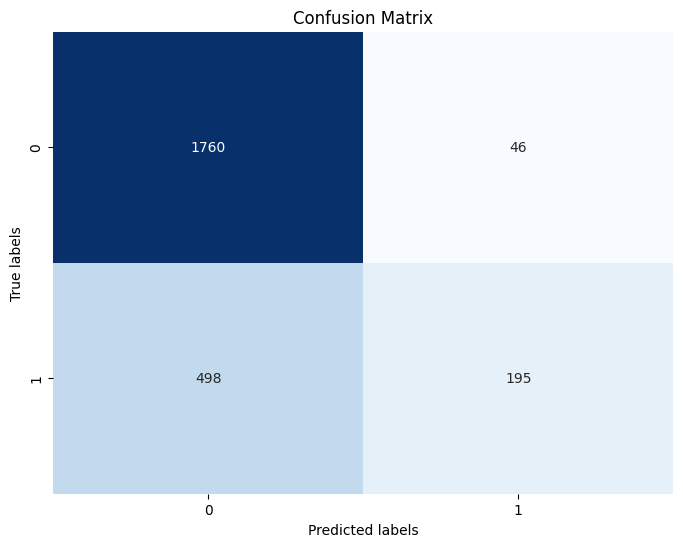

(0.8057979973670958,
 0.26999599629657434,
 0.40439234296137255,
 0.7796096358543417)

In [397]:
glove_custom_fit_evaluate(X, y, rf_classifier)

In [41]:
glove = vocab.GloVe(name='6B', dim=50)
print('Loaded {} words'.format(len(glove.itos)))


.vector_cache/glove.6B.zip: 862MB [08:55, 1.61MB/s]                               
100%|█████████▉| 399999/400000 [00:05<00:00, 73917.29it/s]


Loaded 400000 words


In [10]:
merged_test_df_train.iloc[41889]

description      Estúdio, Condomínio "Palácio Studio Residence"...
host_about       Sou Dinamica, Bem disposta, Optimista e Lutado...
unlisted                                                         0
lang_desc                                                       pt
lang_host                                                       pt
comments         Great location! Close to bars and restaurants ...
lang_comments                                                   en
Name: 731, dtype: object

In [8]:
import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
#merged_test_df_train
merged_test_df_train.to_csv("/Users/huberto/Desktop/merged_test_df_train.csv")

In [9]:

# Load the DataFrame
df = merged_test_df_train

# Filter out rows with missing values in necessary columns
df = df.dropna(subset=['description', 'host_about', 'comments'])

# Extract the necessary columns
text_data = df['description'] + ' ' + df['host_about'] + ' ' + df['comments']
labels = df['unlisted']

# Split the data into train and test sets
text_train, text_test, labels_train, labels_test = train_test_split(text_data, labels, test_size=0.2, random_state=42)

In [10]:
# Tokenize the text and convert it into sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

In [11]:
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(sentence.split()) for sentence in text_train])

sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)

In [12]:
# Pad sequences to have the same length
padded_train = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')
padded_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

In [13]:
# Load pre-trained GloVe word embeddings
embeddings_index = {}
with open('./4.glove_model/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [18]:
embedding_matrix[19]

array([-0.57058001,  0.44183001,  0.70102   , -0.41712999, -0.34057999,
        0.02339   , -0.071537  ,  0.48177001, -0.013121  ,  0.16834   ,
       -0.13389   ,  0.040626  ,  0.15827   , -0.44341999, -0.019403  ,
       -0.009661  , -0.046284  ,  0.093228  , -0.27331001,  0.22849999,
        0.33089   , -0.36474001,  0.078741  ,  0.3585    ,  0.44757   ,
       -0.2299    ,  0.18076999, -0.62650001,  0.053852  , -0.29154   ,
       -0.42559999,  0.62902999,  0.14393   , -0.046004  , -0.21007   ,
        0.48879001, -0.057698  ,  0.37430999, -0.030075  , -0.34494001,
       -0.29701999,  0.15095   ,  0.28248   , -0.16577999,  0.076131  ,
       -0.093016  ,  0.79364997, -0.60488999, -0.18874   , -1.01730001,
        0.31962001, -0.16344   ,  0.54176998,  1.17250001, -0.47874999,
       -3.3842001 , -0.081301  , -0.35280001,  1.83720005,  0.44516   ,
       -0.52666003,  0.99786001, -0.32178   ,  0.033462  ,  1.17830002,
       -0.072905  ,  0.39737001,  0.26166001,  0.33111   , -0.35

In [15]:
padded_test

array([[ 19,   8,   4, ...,   0,   0,   0],
       [ 88,  11,  23, ...,   0,   0,   0],
       [317,  12,   9, ...,   0,   0,   0],
       ...,
       [167,  12,   6, ...,   0,   0,   0],
       [ 19,   8,   4, ...,   0,   0,   0],
       [333, 367,  73, ...,   0,   0,   0]], dtype=int32)

In [16]:
padded_train

array([[115,   5,  35, ...,   0,   0,   0],
       [385, 175,  38, ...,   0,   0,   0],
       [ 40, 865, 320, ...,   0,   0,   0],
       ...,
       [ 19, 193,   3, ...,   0,   0,   0],
       [ 38, 135, 143, ...,   0,   0,   0],
       [ 12,   9, 567, ...,   0,   0,   0]], dtype=int32)

In [19]:
# Create word embedding feature vectors
embedded_train = np.array([embedding_matrix[word] for word in padded_train])
embedded_test = np.array([embedding_matrix[word] for word in padded_test])


: 

: 

In [ ]:
# Train the Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(embedded_train, labels_train)

In [ ]:



# Predict on the test set
predictions = classifier.predict(embedded_test)

# Calculate evaluation metrics
accuracy = accuracy_score(labels_test, predictions)
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
f1 = f1_score(labels_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Transformer

In [2]:
# import fastai, torch, pytorch_transformers
from fastai.text import *
from fastai.metrics import *
import torch
import torch.nn as nn
from pytorch_transformers import RobertaTokenizer
from pytorch_transformers import RobertaModel
# Garbage Collector
import gc 

In [3]:
!pip3 install transformers
!pip3 install ipywidgets --user
!pip3 install torchtext==0.6.0


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
! pip3 install simpletransformers


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 250 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 485 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 8.9 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 206 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 338 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 22.7 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 

In [20]:
from transformers import pipeline
from tensorflow import keras

In [21]:
unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')

RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
No module named 'keras.engine'

In [20]:
merged_test_df_train

,description,host_about,unlisted,lang_desc,lang_host,comments,lang_comments
index,,,,,,,
1,"This is a shared mixed room in our hostel, with shared bathroom.<br />We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.<br /><br /><b>The space</b><br />We offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 an...",Alojamento Local Registro: 20835/AL,0,en,pt,this is a very cozy and comfortable house to stay in.never worry about the safety and the host is very nice.very close to parque metro station.easy to find.,en
1,"This is a shared mixed room in our hostel, with shared bathroom.<br />We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.<br /><br /><b>The space</b><br />We offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 an...",Alojamento Local Registro: 20835/AL,0,en,pt,good<br/>,cy
1,"This is a shared mixed room in our hostel, with shared bathroom.<br />We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.<br /><br /><b>The space</b><br />We offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 an...",Alojamento Local Registro: 20835/AL,0,en,pt,"My first hostel experience, and all I have to say is it will be pretty hard to beat this place!_x000D_<br/>I booked a room for 6 people, and I ended up getting my own room (there's a locker for each person in the room as well) so I knew my belongings were safe since I was the only one with a key card for my room. There's a 5 euro deposit for the keycard, so don't lose it!_x000D_<br/>The bed was more comfortable than mine at home, and if you close the curtains & shades it tunes out any cars driving by._x000D_<br/>You can't ask for a better location, I could see the Parque metro station from...",en
1,"This is a shared mixed room in our hostel, with shared bathroom.<br />We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.<br /><br /><b>The space</b><br />We offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 an...",Alojamento Local Registro: 20835/AL,0,en,pt,"Das Hostel war neu und deshalb funktionierte alles tadellos: Schnelles W-Lan, stabile Hochbetten mit gemütlichen Matratzen, neue Badezimmer mit richtig heißem und starkem Wasser (was für Lissabon nicht selbstverständlich ist!)._x000D_<br/>Das Frühstück war sehr grundlegend, aber für den Nachpreis OK. _x000D_<br/>Direkt gegenüber befindet sich die Metro-Station ""Parque"" und man kommt mit der blauen Linie in nur 3 Stationen in´s Zentrum._x000D_<br/>Sicherlich gibt es zentralerer Hotels mit mehr Extras, aber für den Preis gibt es keinen Gr

NameError: name 'merged_test_df_train' is not defined

In [4]:
from transformers import pipeline
import torch

classifier = pipeline("sentiment-analysis")
classifier(["I've been waiting for a HuggingFace course my whole life.",
            "I hate this so much!"])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


RuntimeError: Failed to import transformers.models.distilbert.modeling_tf_distilbert because of the following error (look up to see its traceback):
No module named 'keras.engine'